# CLASSIFICATION CHALLENGE

# Outline

- [Introduction](#Introduction)
- [Import necessary libraries](#Import)
- [Loading Datasets](#Load)
- [Data Preprocessing](#section-four)
- EDA
  * Analysis of the data
  
- [Classification Models](#)  
- [Feature Egineering](#feature_engineering)
 * [TF-IDF](#tfidf)
 * [WORD2VEC](word2vec) 
- [Pipelines](#Pipelines)
  * [Using TF-IDF](#pipe_tfidf)
  * [Using Word2Vec](#pipe_word2vec)
- [Modelling and Evaluation](#model_eval)
  * [Modelling - Raw tweets](#raw_tweets)
  * [Modelling - Cleaned tweets](#clean_tweets)
  * [Model perfomance (raw tweets vs cleaned tweets)](#rvc)
  * [Model perfomance (tfidf vs word2vec)](tfidfvsword2vec)
- [Ensemble Method](#ensemble)
- [Choosing the champion model](#cham_model)
- [Hyperparameter tunning](#hy_tunning)
- [Predictions](#predictions)
- [Submission](#submission)  
- [Conclusion](#conclusion)
- [Appendix](#appendix)
- [References](#references)
    
    


# Introduction

Companies are constructed around lessening ones environment impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. 

**Problen Statement**

Create a Natural Language Processing model to classify whether or not a person believes in climate change, based on their novel tweet data. 

<a id="comet"></a>
# Starting a Comet experiment
<img src="https://www.comet.ml/images/logo_comet_light.png" width="350" alt="Drawing" style="width: 350px;"/>
We will be using Comet as a form of version control throughout the development of our model

In [1]:
# install comet
# !pip install comet_ml

In [2]:
# importing Experiment from comet
# from comet_ml import Experiment

In [ ]:
# # Linking our current workspace to comet by creating an experiment with our api key:
# experiment = Experiment(
#     api_key="YBjEZqF3vM9CQLf2Lx7GeSw0C",
#     project_name="general",
#     workspace="mpho-mokhokane",
# )

In [3]:
!pip install contractions

     |████████████████████████████████| 245kB 3.7MB/s 
     |████████████████████████████████| 317kB 8.3MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81703 sha256=2f9ace3364bb76765e2a50314e62d2978a17b492280d96a5dda8806c8bb0307d
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


<a id='Import'></a>
# Import necessary libraries

In [4]:
# imports for data visualisation

import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

# imports for Natural Language  Processing
import pandas as pd
import numpy as np
import nltk
import string
import re
import contractions
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from xgboost import XGBRFClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline




<a id='Load'></a>
# Load and view the data

In [45]:
# Importing the train & test data sets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Data Preprocessing

Identifying Missing Values

In [46]:
#Cheching if there are missing values in the Train dataset
train.isna().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [47]:
#Cheching if there are missing values in the Test dataset
test.isna().sum()

message    0
tweetid    0
dtype: int64

Removing Mentions

In [48]:
def mentions(x):
    x = re.sub(r"(?:\@|https?\://)\S+", "", x)
    return x 

train['message'] = train['message'].apply(mentions)
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT Researchers say we have three years to act...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT It's 2016, and a racist, sexist, climate c...",466954


Expand Contractions


In [49]:
train['message'] = train['message'].apply(lambda x: contractions.fix(x))

train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief does not think carbon d...,625221
1,1,it is not like we lack evidence of anthropogen...,126103
2,2,RT Researchers say we have three years to act...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT it is 2016, and a racist, sexist, climate ...",466954


Removing URLs

In [50]:
train['message'] = train['message'].str.replace('http\S+|www.\S+', '', case=False)

Removing Punctuations

In [51]:
def remove_punc(x):
  x = re.sub(r"([^A-Za-z0-9]+)"," ",x)
  return x

train['message'] = train['message'].map(lambda x: remove_punc(str(x)))

Tokenization

In [52]:
nltk.download('punkt')

train['message'] = train['message'].apply(word_tokenize)
train.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,sentiment,message,tweetid
0,1,"[PolySciMajor, EPA, chief, does, not, think, c...",625221
1,1,"[it, is, not, like, we, lack, evidence, of, an...",126103
2,2,"[RT, Researchers, say, we, have, three, years,...",698562
3,1,"[TodayinMaker, WIRED, 2016, was, a, pivotal, y...",573736
4,1,"[RT, it, is, 2016, and, a, racist, sexist, cli...",466954


Removing Retweets

In [53]:
retweet = 'RT'
train['message'] = train['message'].apply(lambda x: [word for word in x if word not in retweet])
train.head(10)

,sentiment,message,tweetid
0,1,"[PolySciMajor, EPA, chief, does, not, think, c...",625221
1,1,"[it, is, not, like, we, lack, evidence, of, an...",126103
2,2,"[Researchers, say, we, have, three, years, to,...",698562
3,1,"[TodayinMaker, WIRED, 2016, was, a, pivotal, y...",573736
4,1,"[it, is, 2016, and, a, racist, sexist, climate...",466954
5,1,"[Worth, a, read, whether, you, do, or, do, not...",425577
6,1,"[Mike, Pence, does, not, believe, in, global, ...",294933
7,1,"[Six, big, things, we, can, ALL, do, today, to...",992717
8,1,"[My, 8yo, nephew, is, inconsolable, He, wants,...",664510
9,1,"[no, offense, but, like, how, do, you, just, n...",260471


Conversion to Lower case

In [54]:
train['message'] = train['message'].apply(lambda x: [word.lower() for word in x])
train.head()

,sentiment,message,tweetid
0,1,"[polyscimajor, epa, chief, does, not, think, c...",625221
1,1,"[it, is, not, like, we, lack, evidence, of, an...",126103
2,2,"[researchers, say, we, have, three, years, to,...",698562
3,1,"[todayinmaker, wired, 2016, was, a, pivotal, y...",573736
4,1,"[it, is, 2016, and, a, racist, sexist, climate...",466954


Removing Stopwords

In [55]:
nltk.download('stopwords')

", ".join(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [56]:
stop_words = set(stopwords.words('english'))
train['message'] = train['message'].apply(lambda x: [word for word in x if word not in stop_words])
train.head()

,sentiment,message,tweetid
0,1,"[polyscimajor, epa, chief, think, carbon, diox...",625221
1,1,"[like, lack, evidence, anthropogenic, global, ...",126103
2,2,"[researchers, say, three, years, act, climate,...",698562
3,1,"[todayinmaker, wired, 2016, pivotal, year, war...",573736
4,1,"[2016, racist, sexist, climate, change, denyin...",466954


Lemmatization

In [57]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

wnl = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
train['pos_tags'] = train['message'].apply(nltk.tag.pos_tag)
train['wordnet_pos'] = train['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

train['message'] = train['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
train.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,sentiment,message,tweetid,pos_tags,wordnet_pos
0,1,"[polyscimajor, epa, chief, think, carbon, diox...",625221,"[(polyscimajor, JJ), (epa, NN), (chief, NN), (...","[(polyscimajor, a), (epa, n), (chief, n), (thi..."
1,1,"[like, lack, evidence, anthropogenic, global, ...",126103,"[(like, IN), (lack, NN), (evidence, NN), (anth...","[(like, n), (lack, n), (evidence, n), (anthrop..."
2,2,"[researcher, say, three, year, act, climate, c...",698562,"[(researchers, NNS), (say, VBP), (three, CD), ...","[(researchers, n), (say, v), (three, n), (year..."
3,1,"[todayinmaker, wire, 2016, pivotal, year, war,...",573736,"[(todayinmaker, NN), (wired, VBD), (2016, CD),...","[(todayinmaker, n), (wired, v), (2016, n), (pi..."
4,1,"[2016, racist, sexist, climate, change, deny, ...",466954,"[(2016, CD), (racist, NN), (sexist, NN), (clim...","[(2016, n), (racist, n), (sexist, n), (climate..."


Most Frequent Words

In [58]:
from collections import Counter
cnt = Counter()
for message in train['message'].values:
    for word in message:
        cnt[word] += 1
        
cnt.most_common()

[('climate', 13020),
 ('change', 12811),
 ('global', 3798),
 ('trump', 2437),
 ('warming', 2324),
 ('believe', 1311),
 ('warm', 1286),
 ('say', 1029),
 ('think', 1002),
 ('go', 946),
 ('amp', 940),
 ('u', 823),
 ('world', 747),
 ('real', 724),
 ('make', 671),
 ('fight', 636),
 ('people', 625),
 ('epa', 569),
 ('president', 569),
 ('scientist', 554),
 ('via', 547),
 ('new', 547),
 ('science', 488),
 ('like', 480),
 ('die', 463),
 ('hoax', 458),
 ('year', 425),
 ('denier', 420),
 ('right', 409),
 ('know', 408),
 ('get', 398),
 ('donald', 391),
 ('need', 389),
 ('take', 383),
 ('want', 382),
 ('would', 348),
 ('deny', 341),
 ('call', 336),
 ('elect', 325),
 ('action', 323),
 ('husband', 317),
 ('could', 317),
 ('china', 314),
 ('human', 310),
 ('one', 304),
 ('stop', 304),
 ('time', 302),
 ('cause', 292),
 ('news', 279),
 ('man', 278),
 ('talk', 277),
 ('tell', 271),
 ('big', 270),
 ('pruitt', 266),
 ('issue', 265),
 ('energy', 260),
 ('look', 256),
 ('thing', 255),
 ('see', 245),
 ('obam

Separate Datframes of Tweets for each Sentiment

In [59]:
train.sentiment.value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In [60]:
#sentiment value 0
sentiment_0 = train[train['sentiment'] == 0]
sentiment_0.head()

,sentiment,message,tweetid,pos_tags,wordnet_pos
19,0,"[calum, tweet, abt, reunitingish, w, cast, see...",547924,"[(calum, NN), (tweets, NNS), (abt, VBP), (reun...","[(calum, n), (tweets, n), (abt, v), (reuniting..."
22,0,"[also, meet, guy, let, u, truth, climate, chan...",67545,"[(also, RB), (met, VBN), (guy, NN), (let, VB),...","[(also, r), (met, v), (guy, n), (let, v), (us,..."
30,0,"[scientist, denounce, climate, change, choice]",365051,"[(scientists, NNS), (denounce, NN), (climate, ...","[(scientists, n), (denounce, n), (climate, n),..."
39,0,"[dealt, simple, issue, like, climate, change, ...",403368,"[(dealt, JJ), (simple, JJ), (issues, NNS), (li...","[(dealt, a), (simple, a), (issues, n), (like, ..."
43,0,"[win, probability, bullshit, man, saw, nba, fi...",326916,"[(win, JJ), (probability, NN), (bullshit, NN),...","[(win, a), (probability, n), (bullshit, n), (m..."


In [61]:
#sentiment value 1
sentiment_1 = train[train['sentiment'] == 1]
sentiment_1.head()

,sentiment,message,tweetid,pos_tags,wordnet_pos
0,1,"[polyscimajor, epa, chief, think, carbon, diox...",625221,"[(polyscimajor, JJ), (epa, NN), (chief, NN), (...","[(polyscimajor, a), (epa, n), (chief, n), (thi..."
1,1,"[like, lack, evidence, anthropogenic, global, ...",126103,"[(like, IN), (lack, NN), (evidence, NN), (anth...","[(like, n), (lack, n), (evidence, n), (anthrop..."
3,1,"[todayinmaker, wire, 2016, pivotal, year, war,...",573736,"[(todayinmaker, NN), (wired, VBD), (2016, CD),...","[(todayinmaker, n), (wired, v), (2016, n), (pi..."
4,1,"[2016, racist, sexist, climate, change, deny, ...",466954,"[(2016, CD), (racist, NN), (sexist, NN), (clim...","[(2016, n), (racist, n), (sexist, n), (climate..."
5,1,"[worth, read, whether, believe, climate, change]",425577,"[(worth, JJ), (read, VBD), (whether, IN), (bel...","[(worth, a), (read, v), (whether, n), (believe..."


In [62]:
#sentiment value 2
sentiment_2 = train[train['sentiment'] == 2]
sentiment_2.head()

,sentiment,message,tweetid,pos_tags,wordnet_pos
2,2,"[researcher, say, three, year, act, climate, c...",698562,"[(researchers, NNS), (say, VBP), (three, CD), ...","[(researchers, n), (say, v), (three, n), (year..."
12,2,"[5, percent, chance, avoid, dangerous, global,...",454673,"[(5, CD), (percent, NN), (chance, NN), (avoidi...","[(5, n), (percent, n), (chance, n), (avoiding,..."
14,2,"[fossil, fuel, giant, exxonmobil, mislead, pub...",658092,"[(fossil, NN), (fuel, NN), (giant, NN), (exxon...","[(fossil, n), (fuel, n), (giant, n), (exxonmob..."
26,2,"[bangladesh, confront, climate, change, head]",365291,"[(bangladesh, JJ), (confronting, VBG), (climat...","[(bangladesh, a), (confronting, v), (climate, ..."
32,2,"[atmospheric, river, fuel, climate, change, co...",143471,"[(atmospheric, JJ), (rivers, NNS), (fueled, VB...","[(atmospheric, a), (rivers, n), (fueled, v), (..."


In [63]:
#sentiment value -1
sentiment__1 = train[train['sentiment'] == -1]
sentiment__1.head()

,sentiment,message,tweetid,pos_tags,wordnet_pos
28,-1,"[sally, kohn, late, evidence, climate, change,...",355491,"[(sally, RB), (kohn, JJ), (latest, JJS), (evid...","[(sally, r), (kohn, a), (latest, a), (evidence..."
46,-1,"[carbon, tax, globalist, idea, enslave, world,...",61141,"[(carbon, NN), (tax, NN), (globalist, NN), (id...","[(carbon, n), (tax, n), (globalist, n), (idea,..."
48,-1,"[wind, close, 100, mph, area, afternoon, would...",719523,"[(winds, NNS), (close, RB), (100, CD), (mph, N...","[(winds, n), (close, r), (100, n), (mph, n), (..."
56,-1,"[lmao, snowflake, complain, snowflake, winter,...",911385,"[(lmao, NN), (snowflakes, NNS), (complaining, ...","[(lmao, n), (snowflakes, n), (complaining, v),..."
57,-1,"[one, arnold, schwarzenegger, vehicle, whine, ...",768263,"[(one, CD), (arnold, JJ), (schwarzenegger, NN)...","[(one, n), (arnold, a), (schwarzenegger, n), (..."


# Exploratory Data Analysis
- A detailed section will be added...

Text(0.5, 1.05, 'Sentiments Frequency Count')

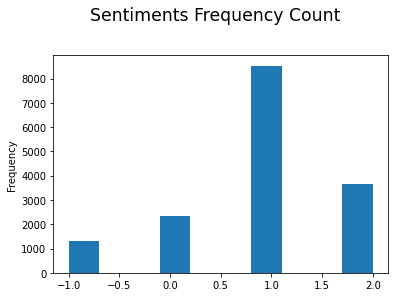

In [64]:
train["sentiment"].plot.hist()
# set title and axis labels
plt.suptitle('Sentiments Frequency Count', x=0.5, y=1.05, ha='center', fontsize='xx-large')

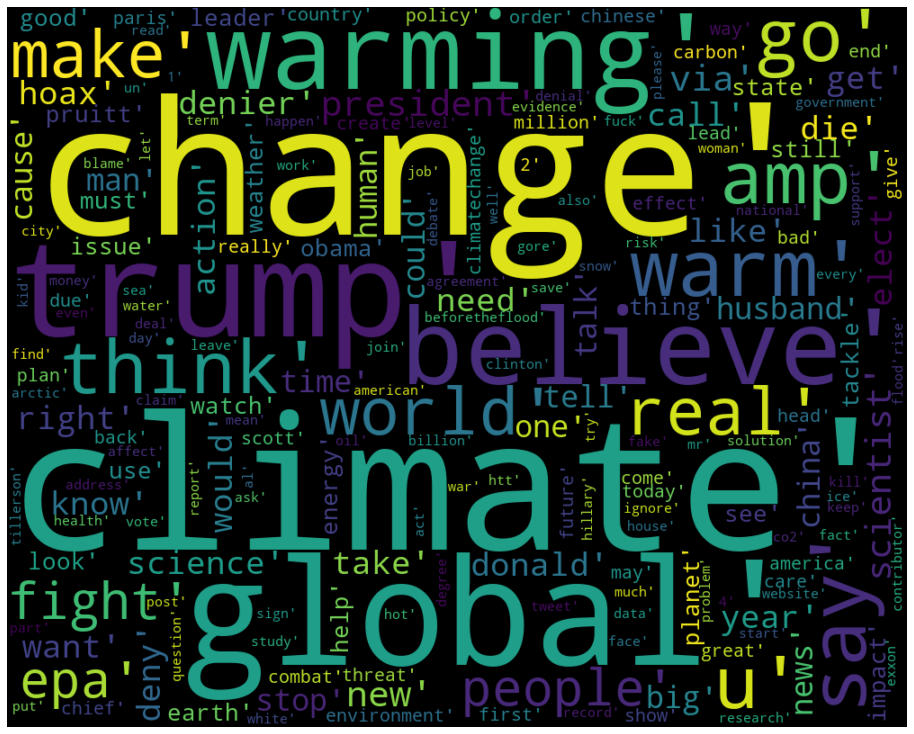

In [65]:
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

words = train['message']
allwords = []
for wordlist in words:
    allwords += wordlist
    
mostcommon = FreqDist(allwords).most_common(1000)
wordcloud = WordCloud(width=1000, height=800, background_color='black').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

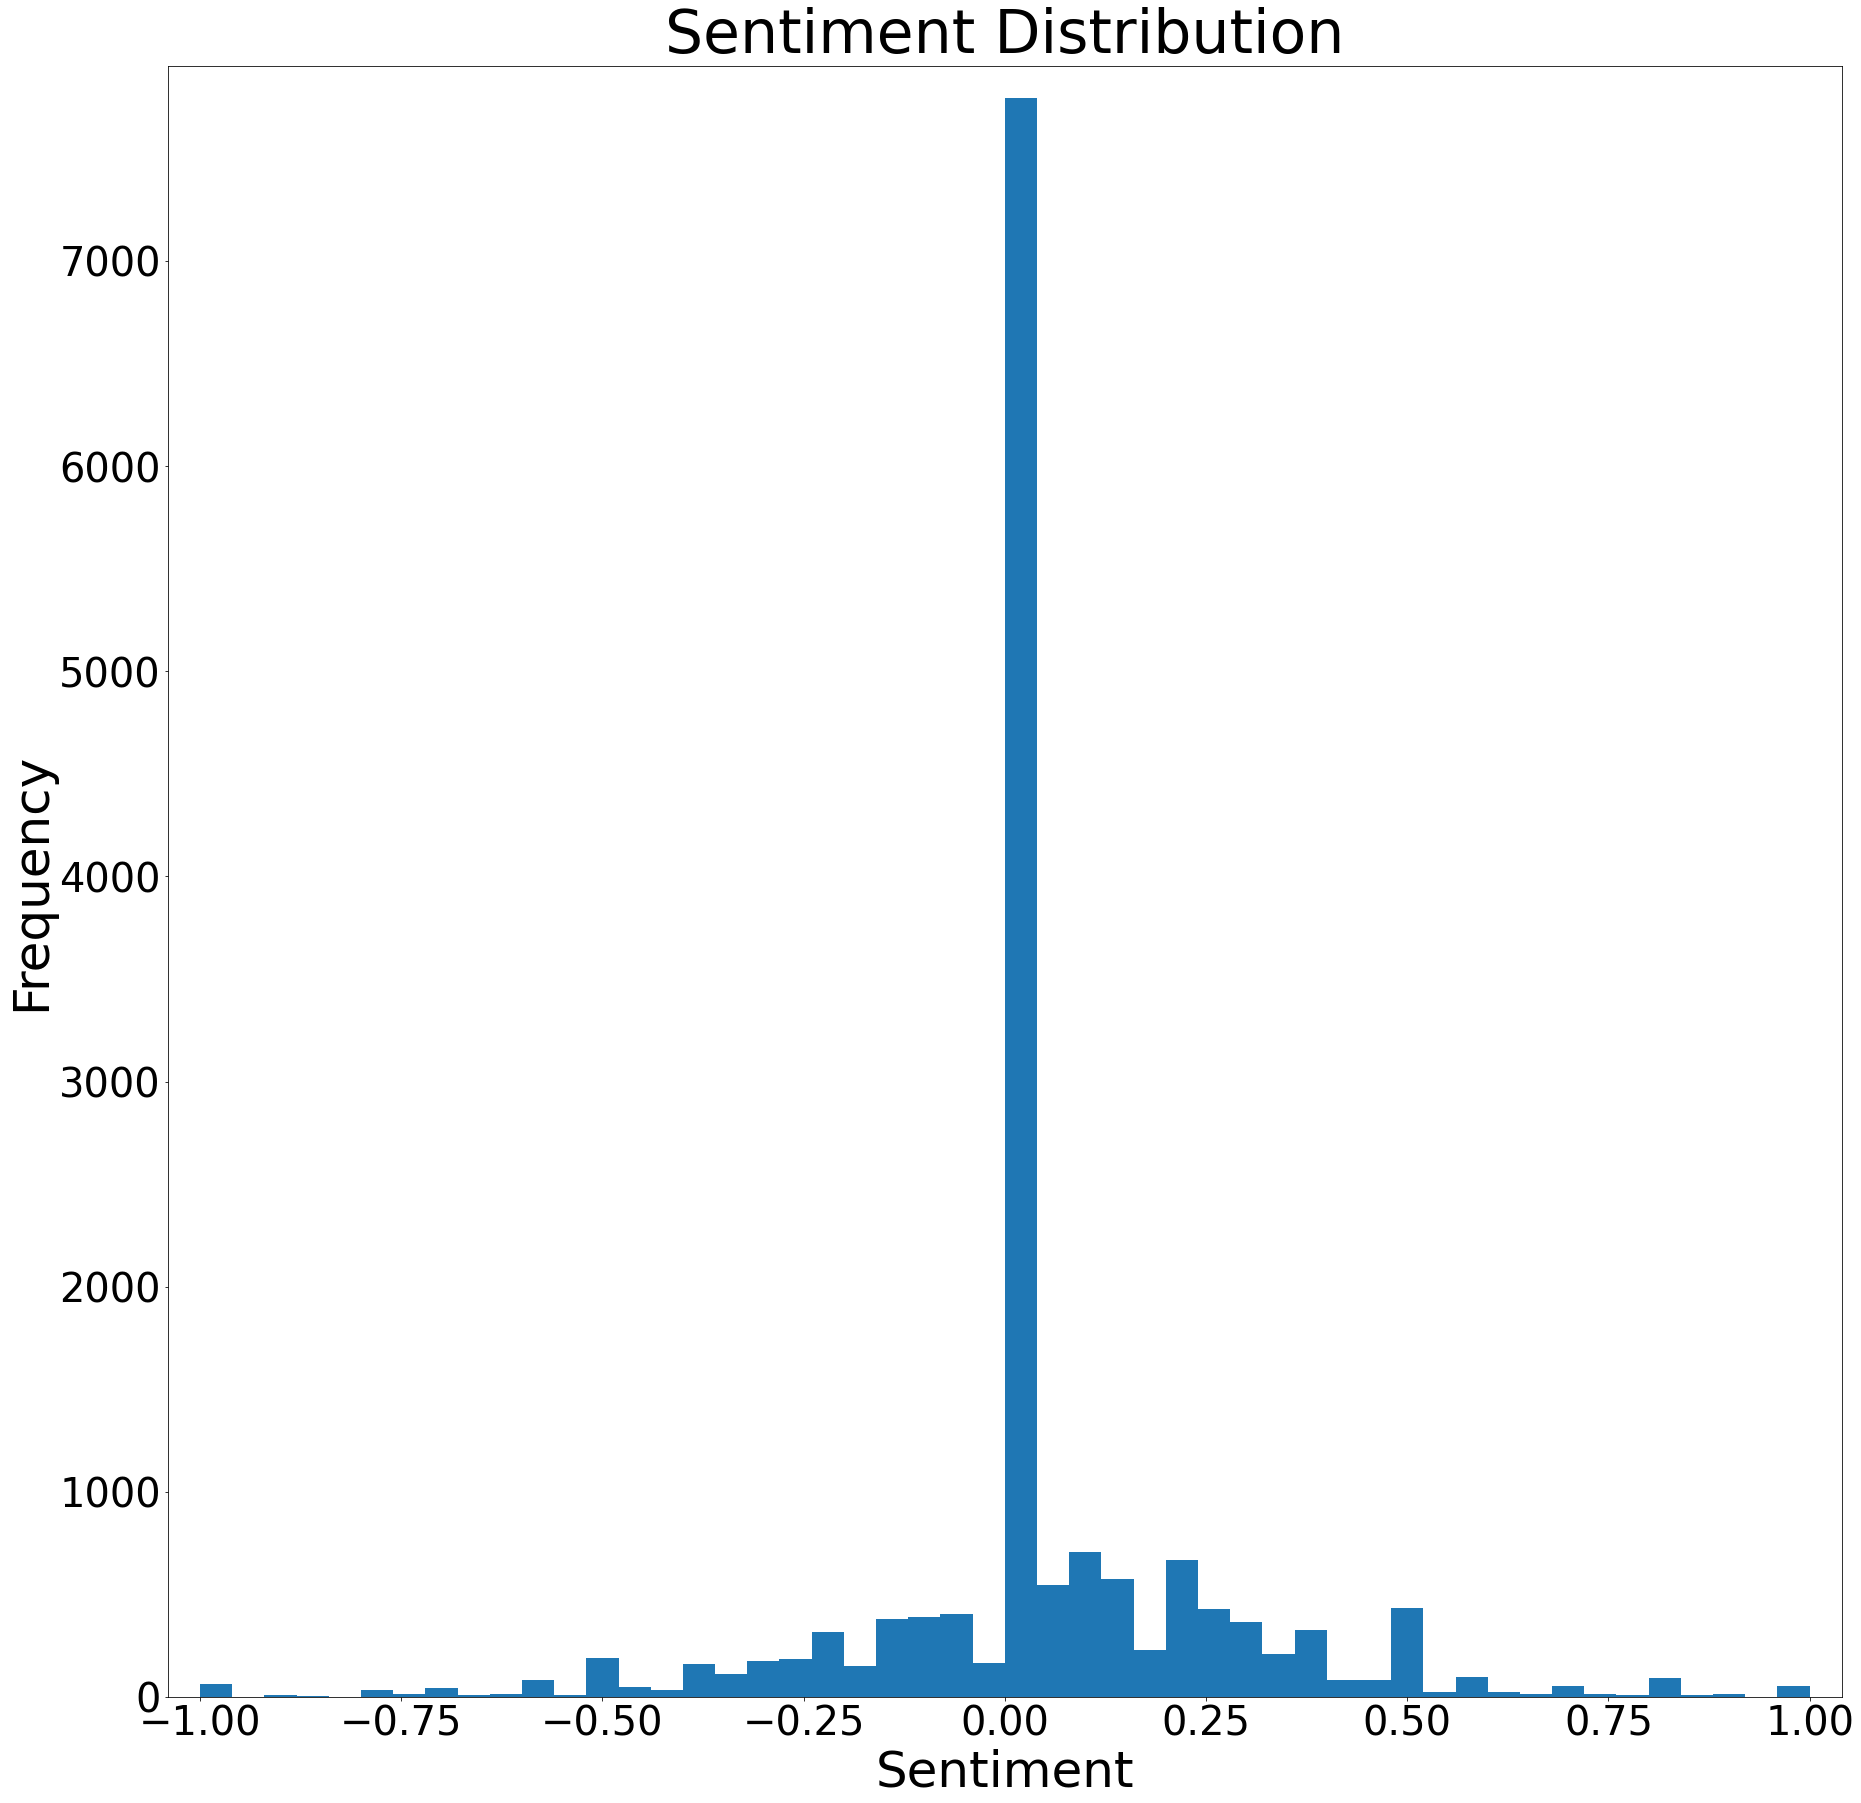

In [66]:
#Compare the sentiment analysis 
train2 = pd.read_csv('train.csv')
from textblob import TextBlob
train['sentiment_2']=train2['message'].apply(lambda x:TextBlob(x).sentiment.polarity)
plt.figure(figsize=(30,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(train['sentiment_2'], bins=50)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

<a id='basemodels'></a>
# Classification Models
We're going to look at the following models,

*  Decision Tree Classifier<a id='DS'></a>
*  RandomForest Classifier<a id='random'></a>
*  LinearSVC(Support Vector Classifier)<a id='svc'></a>
*  LGBMClassifier(Light Gradient Boosting Machine Classifier)<a id='LGBM'></a>


<a id='tree'></a>
## Tree-based Models for Classification

<a id='DC'></a>
### Decision Tree Classifier

![1*bcLAJfWN2GpVQNTVOCrrvw.png](https://miro.medium.com/max/688/1*bcLAJfWN2GpVQNTVOCrrvw.png)
Decision Trees (DTs) are  non-parametric supervised learning methods used for classification and regression. Decision trees learn from data to approximate a sine curve with a set of if-then-else decision rules. The deeper the tree, the more complex the decision rules and the fitter the model.

Decision tree builds classification or regression models in the form of a tree structure. It breaks down data by partitioning it into subsets after each decision while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes. A decision node has two or more branches. Leaf node represents a classification or decision. The topmost decision node in a tree which corresponds to the best predictor called root node. Decision trees can handle both categorical and numerical data.

Visual representation of a `Decision Tree`
![1*WerHJ14JQAd3j8ASaVjAhw.jpeg](https://miro.medium.com/max/963/1*WerHJ14JQAd3j8ASaVjAhw.jpeg)


Decision trees are prone to overfitting. Overfitting happens when the learning algorithm continues to develop hypotheses that reduce training set error at the cost of an increased test set error; One method to tackle overfitting in decision trees is by **prunning**.
There are several approaches used to avoid overfitting in building decision trees namely, 		
- Pre-pruning that stops growing the tree earlier, before it perfectly classifies the training set.
- Post-pruning that allows the tree to perfectly classify the training set, and then post prune the tree. 
Practically, the second approach of post-pruning overfit trees is more successful because it is not easy to precisely estimate when to stop growing the tree.

Decision Trees are building blocks for the next machine learning method we will look into, which is the **Random Forest Classifier**

<a id='random'></a>
### Random Forest Classifier
`Random forest` is a supervised learning algorithm that can be used both for classification and regression. A forest is comprised of a number of individual trees. It is said that the more trees it has, the more robust a forest is, unlike decision trees `Random Forest`  prevents overfitting by creating trees on random subsets  

The Random forest algorithm works in four steps

 1. Selects a number of random samples from a given dataset
 2. Construct a decision tree for each sample and get a prediction result from each decision tree
 3. Perform a vote for each predicted result.
 4. Select the prediction result with the most votes as the final prediction.

a visual representation of a Random Forest classifier is seen in the diagram below
![voting_dnjweq.jpg](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1526467744/voting_dnjweq.jpg)





## Support Vector Classification(LinearSVC)
SVM or Support Vector Machine is a linear model for classification and regression problems. It can solve linear and non-linear problems and work well for many practical problems. The idea of SVM is simple: The algorithm creates a line or a hyperplane which separates the data into classes as seen in the diagram below

![1*dh0lzq0QNCOyRlX1Ot4Vow.jpeg](https://miro.medium.com/max/963/1*dh0lzq0QNCOyRlX1Ot4Vow.jpeg)

To better explain the concept of `SVM` we will look at a case of two classes.

**To find the best line seperating the classes**

The `SVM` algorithm finds the points closest to the line from both the classes.These points are called support vectors, then it compute the distance between the line and the support vectors, This distance is called the margin. Our goal is to maximize the margin.

In a case for more than two classes the goal is to find the the best hyperplane that seperates the classes.
The hyperplane for which the margin is maximum is the optimal hyperplane.

Below is a visual representation of how `SVMs` work

<p float="left">
  <img src="https://miro.medium.com/max/880/1*VDATmWG1E1ZNg7hdasOh5g.png" width="400" />
  <img src="https://miro.medium.com/max/880/1*AMR3v-jCvUMXPUtQskzxmQ.png" width="400" />
  <img src="https://miro.medium.com/max/880/1*irg_jfdAar9gfe0j-Q04vQ.png" width="400" />
</p>





## Light Gradient Boosting Machine(LightGBM)
LightGBM is a gradient boosting framework that also uses a tree based learning algorithm. LightGBM differes from other tree based algorithms in the sense that it grows trees vertifically while other algorithms grow them horizontally, this means that Light GBM grows trees leaf-wise while other algorithm grow level-wise.

LightGBM will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.
The diagrams below explain the implementation of LightGBM and other boosting algorithms


How Light GBM works![1*AZsSoXb8lc5N6mnhqX5JCg.png](https://miro.medium.com/max/875/1*AZsSoXb8lc5N6mnhqX5JCg.png)

How other tree based algorithms work
![1*whSa8rY4sgFQj1rEcWr8Ag.png](https://miro.medium.com/max/875/1*whSa8rY4sgFQj1rEcWr8Ag.png)

some adcantages of LightGBM framework include
- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel and GPU learning.
- Capable of handling large-scale data

# Creating our X and y Metrics

In [ ]:
X = train['message']
y = train['sentiment']

# Splitting data into train and validation sets

Separating data into training and validation sets is an important part of evaluating our models. 
In our case we will randomly split the train data into 70% train and 30% validation. 
After our model is trained with the train data we then use it to make predictions for the target using the validation set,Because the data in the validation set already contains known values for the target variable this will make it easy  for us to asses our model's accuracy.

In [ ]:
# Splitting the data into 70% train and 30% validation set
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=.3,shuffle=True, stratify=y, random_state=11)

<a id='feature_engineering'></a>
# Feature Engineering
We will be looking at two methods of feature selection in text data namely the `tfidfVectorizer` and `word2vec`

<a id='tfidf'></a>
`TF-IDF` stands for Term Frequency — Inverse Document Frequency and is a statistic that aims to better define how important a word is for a document, while also taking into account the relation to other documents from the same corpus.
This is performed by looking at how many times a word appears into a document while also paying attention to how many times the same word appears in other documents in the corpus.
`vocabulary_` Is a dictionary that converts each word in the text to feature index in the matrix, each unique token gets a feature index

<a id='word2vec'></a>
**WORD2VEC EMBEDDINGS AS FEATURES**

`Word2vec` is a predictive deep learning based model to compute and generate high quality, distributed and continuous dense vector representations of words, which capture contextual and semantic similarity. Essentially these are unsupervised models which can take in massive textual corpora, create a vocabulary of possible words and generate dense word embeddings for each word in the vector space representing that vocabulary. 
The main idea is to encode words with close meaning that can substitute each other in a context as close vectors in an X-dimensional space, although this method is generally used for unsupervised learnining it can also be used in supervised learning.





<a id='Pipelines'></a>
# Pipelines
![cover.png](https://www.houseofbots.com/images/news/11939/cover.png)
`Pipeline`  by definition is a tool that sequentially applies a list of transforms and a final estimator. Intermediate steps of pipeline implement fit and transform methods and the final estimator only needs to implement fit. In our case pipelines will help us tranform the train, validation and test data as well as train our models.

Since our models can only process numerical data our first step is to build a pipeline that converts text data into numeric data, In this notebook we will be focusing on two methods of feature engineering, which we will use to convert text data to numeric data, namely TfidfVectorizer and Word2Vec, then we will train our models within these pipelines

We will be building two sets of pipelines one with features generated using `tfidfVectorizer` and the second one using `word2vec` embeddings as features

<a id='model_eval'></a>
# Modelling and Evaluation

<a id='raw_tweets'></a>
## Modelling - Raw tweets
* We doing this so that later we can check if our preprocessing steps actually improved model performances

In [ ]:
# DecisionTreeClassifier Pipeline
tree = Pipeline([('tfidf', TfidfVectorizer()),('tree', DecisionTreeClassifier()),])
#training the decision tree pipeline
tree.fit(X_train, y_train)


# RandomForestClassifier Pipeline
rfc = Pipeline([('tfidf', TfidfVectorizer()), ('rfc', RandomForestClassifier())])
# training the RandomForest pipleline
rfc.fit(X_train, y_train)


# LinearSVC Pipeline
svc = Pipeline([('tfidf', TfidfVectorizer()),
                     ('scv', LinearSVC()),])
# training the LinearSVC pipeline
svc.fit(X_train, y_train)  



# LGBMClassifier Pipeline
lgbm = Pipeline([('tfidf', TfidfVectorizer()), ('lgbm', LGBMClassifier())])
# training the LGBMClassifier Pipleine
lgbm.fit(X_train, y_train)



Pipeline(steps=[('tfidf', TfidfVectorizer()), ('lgbm', LGBMClassifier())])

<a id='model_eval'></a>
## Model evalution

To evaluate the base models we first start with making predictions for the validation set

In [ ]:
# Making validations set predicions

tree_prediction = tree.predict(X_val) # DecisionTreeClassifier predictions
rfc_prediction = rfc.predict(X_val) # RandomForestClassifier predictions
svc_prediction = svc.predict(X_val) # LinearSVClassifier Predictions
lgbm_prediction = lgbm.predict(X_val) # LGBMClassifier Model predictions

### Evalution of DecisionTreeClassifier

In [ ]:
# Report the confusion matrix

print('\nDecision Tree\n', confusion_matrix(y_val, tree_prediction))



Decision Tree
 [[ 106   71  157   55]
 [  41  281  330   54]
 [  88  300 1834  337]
 [  21   74  341  656]]


In [ ]:
# Print a classification report

print('\nDecision Tree\n', classification_report(y_val, tree_prediction))




Decision Tree
               precision    recall  f1-score   support

          -1       0.41      0.27      0.33       389
           0       0.39      0.40      0.39       706
           1       0.69      0.72      0.70      2559
           2       0.60      0.60      0.60      1092

    accuracy                           0.61      4746
   macro avg       0.52      0.50      0.51      4746
weighted avg       0.60      0.61      0.60      4746



In [ ]:
# Print the overall accuracy
print('\nDecision Tree accuracy Score\n', round(accuracy_score(y_val, tree_prediction),2))
print('\nDecision Tree macro f1 score\n', round(f1_score(y_val, tree_prediction, average="macro"),2))



Decision Tree accuracy Score
 0.61

Decision Tree macro f1 score
 0.51


### Evalution of RandomForestClassifier

In [ ]:
print('\nRandomForestClassifier\n', confusion_matrix(y_val, rfc_prediction))



RandomForestClassifier
 [[  47   36  286   20]
 [   2  213  449   42]
 [   1   50 2319  189]
 [   0    3  332  757]]


In [ ]:
print('\nRandomForestClassifier\n', classification_report(y_val, rfc_prediction))



RandomForestClassifier
               precision    recall  f1-score   support

          -1       0.94      0.12      0.21       389
           0       0.71      0.30      0.42       706
           1       0.68      0.91      0.78      2559
           2       0.75      0.69      0.72      1092

    accuracy                           0.70      4746
   macro avg       0.77      0.51      0.53      4746
weighted avg       0.72      0.70      0.67      4746



In [ ]:
print('\nRandomForestClassifier accuracy score\n', round(accuracy_score(y_val, rfc_prediction),2))
print('\nRandomForestClassifier macro f1 score\n', round(f1_score(y_val, rfc_prediction, average="macro"),2))


RandomForestClassifier accuracy score
 0.7

RandomForestClassifier macro f1 score
 0.53


### Evaluation of LinearSVClassifier

In [ ]:
print('\nSVC Model\n', confusion_matrix(y_val, svc_prediction))


SVC Model
 [[ 158   53  148   30]
 [  31  265  340   70]
 [  35   95 2203  226]
 [   6   15  191  880]]


In [ ]:
print('\nSVC Model\n', classification_report(y_val, svc_prediction))



SVC Model
               precision    recall  f1-score   support

          -1       0.69      0.41      0.51       389
           0       0.62      0.38      0.47       706
           1       0.76      0.86      0.81      2559
           2       0.73      0.81      0.77      1092

    accuracy                           0.74      4746
   macro avg       0.70      0.61      0.64      4746
weighted avg       0.73      0.74      0.72      4746



In [ ]:
# # Visual represetation of of the f1 score for each class
# report_svc = classification_report(y_val, svc_prediction, output_dict=True)
# df_svc = pd.DataFrame(report_svc).transpose()
# df_svc.drop(['accuracy'], inplace = True)
# df_svc.sort_values(by=['f1-score'],ascending=True, inplace = True)
# df_svc.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
# plt.xlabel('f1-score')
# plt.ylabel('Classes')
# plt.yticks(rotation = 40)
# plt.title('fi-score for each class')
# plt.show()

In [ ]:
print('\nSVC Model accuracy score\n', round(accuracy_score(y_val, svc_prediction),2))

print('\nSVC Model macro f1 score\n', round(f1_score(y_val, svc_prediction, average="macro"),2))


SVC Model accuracy score
 0.74

SVC Model macro f1 score
 0.64


### Evaluation of LGBMClassifier

In [ ]:
print('\nLightGBM\n', confusion_matrix(y_val, lgbm_prediction))


LightGBM
 [[  77   59  223   30]
 [  11  278  372   45]
 [  20  110 2187  242]
 [   3   26  265  798]]


In [ ]:
print('\nLightGBM\n', classification_report(y_val, lgbm_prediction))


LightGBM
               precision    recall  f1-score   support

          -1       0.69      0.20      0.31       389
           0       0.59      0.39      0.47       706
           1       0.72      0.85      0.78      2559
           2       0.72      0.73      0.72      1092

    accuracy                           0.70      4746
   macro avg       0.68      0.54      0.57      4746
weighted avg       0.70      0.70      0.68      4746



In [ ]:
# # Visual represetation of of the f1 score for each class
# report_lgbm = classification_report(y_val, lgbm_prediction, output_dict=True)
# df_lgbm = pd.DataFrame(report_lgbm).transpose()
# df_lgbm.drop(['accuracy'], inplace = True)
# df_lgbm.sort_values(by=['f1-score'],ascending=True, inplace = True)
# df_lgbm.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8))
# plt.xlabel('f1-score')
# plt.ylabel('Classes')
# plt.yticks(rotation = 40)
# plt.title('fi-score for each class')
# plt.show()

In [ ]:
print('\nLightGBM accuracy score\n', round(accuracy_score(y_val, lgbm_prediction),2))
print('\nLightGBM macro f1 score\n', round(f1_score(y_val, lgbm_prediction, average="macro"),2))


LightGBM accuracy score
 0.7

LightGBM macro f1 score
 0.57


### Comparison of base models

In [ ]:
classifier_scores = {'Classifiers':['Decision Tree', 'Random Forest','LinearSVC','LGBM'],
                    'Accuracy':[0.6,0.7,0.74,0.7],'macro f1 Score':[0.49,0.53,0.64,0.57]}
df= pd.DataFrame(classifier_scores)

In [ ]:
df.sort_values(by=['Accuracy'],ascending=True, inplace = True)

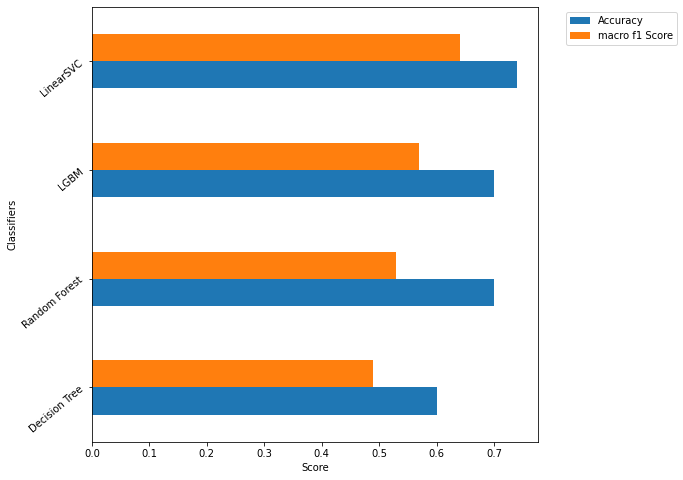

In [ ]:
df.set_index(df['Classifiers'], inplace = True)
df.drop(['Classifiers'],axis = 1)
df.plot(kind='barh', figsize = (8,8))
plt.xlabel('Score')
plt.yticks(rotation = 40)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

<a id='clean_tweets'></a>
## Modelling - Cleaned tweets

## TF-IDF

In [ ]:
# build pipepiles with cleaned tweets and evaluate them

## Word2Vec

In [ ]:
# Checking model perfomance before and after data processing

In [ ]:
# Checking model perfomance with tfidfvectorizer and word2vec embeddings

## Pipelines using TF-IDF Features

## Pipelines using Word2Vec Features

## Model Evaluation
* look at the performance of each model using  metrics like accuracy, Confusion matricx, classification report, F1 and accurary.

# Visualize Model perfomances based on F1 score
* bar plot

<a id='ensemble'></a>
# Ensembel Method
*  voting classifer 

<a id='cham_model'></a>
# Choosing the champion model


<a id='hy_tunning'></a>
# Hyperparameter Tunning
* Select top 3 best performing models
* Methods
  * Randomized Search
  * GridSearchCV
  * KfoldCross Validation

<a id='predictions'></a>
# Final prediction

<a id='submission'></a>
# Creating an output csv for submission
* create a csv file with prediction from our best performing model

In [ ]:
# test['sentiment'] = y_pred

In [ ]:
# test[['tweetid','sentiment']].to_csv('testsubmission.csv', index=False)

In [ ]:
t

In [ ]:
# close the experiment
#experiment.end()

In [ ]:
#experiment.display()

<a id='conclusion'></a>
# Conclusion


<a id='appendix'></a>
# Appendix
* Things we did but couldnt fit anywhere in the notebook

<a id='references'></a>
# References

TF-IDF Explained And Python Sklearn Implementation :
https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275

Decision Trees Explained Easily :
https://medium.com/@chiragsehra42/decision-trees-explained-easily-28f23241248

Understanding Random Forests Classifiers in Python :
https://www.datacamp.com/community/tutorials/random-forests-classifier-python

What is LightGBM, How to implement it? How to fine tune the parameters?
https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

Using word2vec embeddings as featrues :
https://www.kaggle.com/vladislavkisin/word2vec-in-supervised-nlp-tasks-shortcut

A hands-on intuitive approach to Deep Learning Methods for Text Data — Word2Vec, GloVe and FastText
https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa